In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# DBSCAN
A density based type of clustering method.

## The Algorithm in a Nutshell

* A point is a **core** if it has more than minPts points within eps
* A point is a **border** if it has less than minPts points within eps but one of its neighboors is a core point
* A **noise** point is neither a core or a border point


1. Label all points as core, border or noise points
1. Eliminate noise points.
1. Put an edge between all core points that are within eps of each other
1. Make each group of connected core points into a separate cluster.
1. Assign each border point to one of the clusters of its associated core points.

> Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, No. 34, pp. 226-231).

Running [example](http://matlaspisa.isti.cnr.it:5055/Dbscan)  
Wikipedia [link](https://en.wikipedia.org/wiki/DBSCAN)

## DBSCAN Problems

* Parameter tuning
* Does not recognize different densities

## Improvements
* By exploiting the expectation of increased number of points when increasing the eps, you can create a ratio between points that better recognizes different densities, as well as noise.

In [2]:
# Clustering by user account
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            11109 non-null  int64  
 1   name                               11108 non-null  object 
 2   lang                               11109 non-null  object 
 3   bot                                11109 non-null  int64  
 4   created_at                         11109 non-null  object 
 5   statuses_count                     11109 non-null  int64  
 6   account_age_in_days                11109 non-null  int64  
 7   number_of_tweets                   11109 non-null  int64  
 8   account_average_tweets_per_day     11109 non-null  float64
 9   avg_tweets_per_actual_day          11109 non-null  float64
 10  day_with_most_tweets               11109 non-null  object 
 11  max_number_of_tweets_in_a_day      11109 non-null  int

## Clustering Preprocessing - Feature Selection
In order to avoid the curse of dimensionality, one needs to reduce the number of features.
It is also considered good practice to remove features that have a high correlation, so that you are not weighting a certain behaviour more than any other.  

C:\Users\admin\AppData\Local\Temp\ipykernel_32244\1237290582.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfCorr = users_df.corr(method="spearman")


<Figure size 1600x600 with 0 Axes>

<AxesSubplot: >

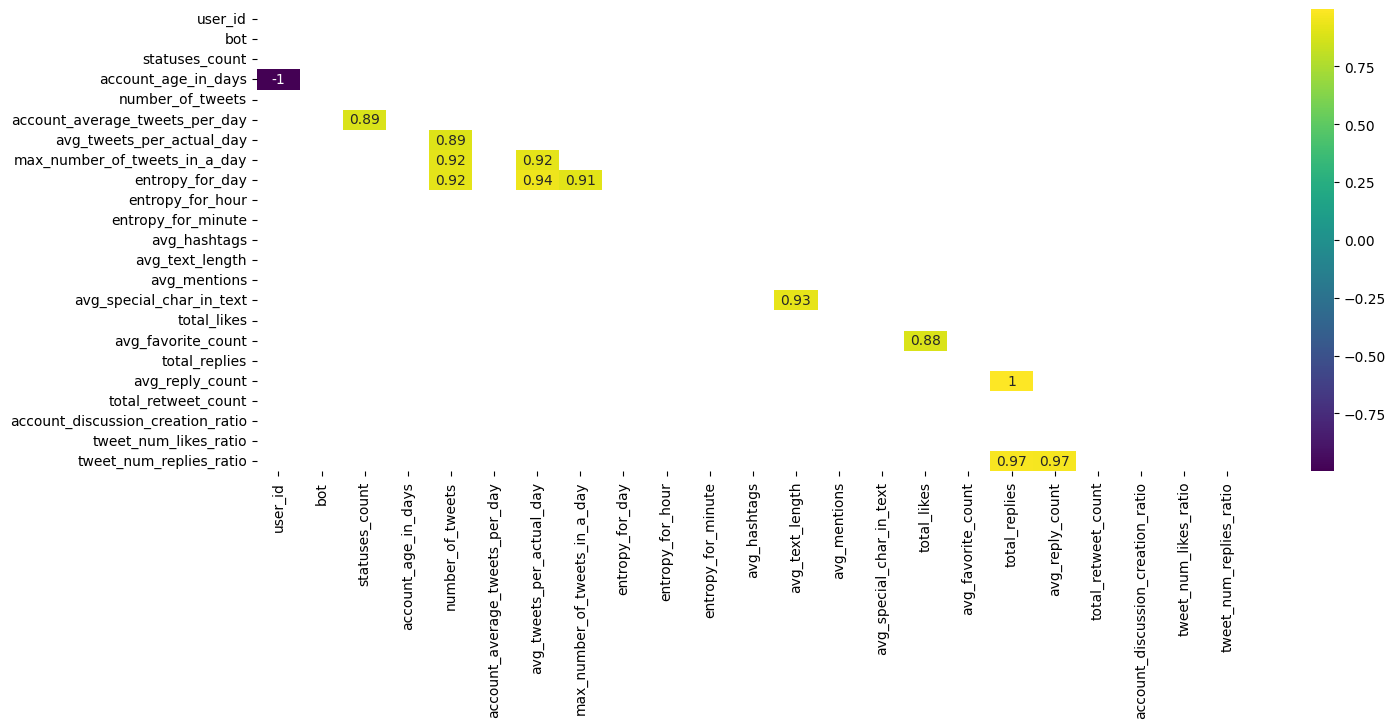

In [3]:
dfCorr = users_df.corr(method="spearman")
filteredDf = dfCorr[((dfCorr >= .8) | (dfCorr <= -.8)) & (dfCorr !=1.000)] # We need to find the best correlation treshold
# https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm#:~:text=Correlation%20coefficients%20whose%20magnitude%20are%20between%200.7%20and%200.9%20indicate,can%20be%20considered%20moderately%20correlated.
plt.figure(figsize=(16,6))
sns.heatmap(filteredDf, annot=True, cmap="viridis",mask=np.triu(filteredDf))
plt.show()

Dropping the following columns, prioritizing to only keep the features with a higher degree of behaviour symbolisys, as well as only numerical features:

Non-Numerical features:
* user_id
* bot
* created_at
* name
* lang
* day_with_most_tweets

High-correlation features:
* statuses_count
* avg_tweets_per_actual_day
* max_number_of_tweets_in_a_day
* entropy_for_day
* avg_special_char_in_text
* total_likes
* total_replies
* avg_reply_count

In [4]:
columns_to_drop = ["user_id", "bot", "created_at", "name", "lang", "day_with_most_tweets", "statuses_count", "avg_tweets_per_actual_day", "max_number_of_tweets_in_a_day", "entropy_for_day", "avg_special_char_in_text", "total_likes", "total_replies", "avg_reply_count"]

In [5]:
users_df = users_df.drop(columns=columns_to_drop)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   account_age_in_days                11109 non-null  int64  
 1   number_of_tweets                   11109 non-null  int64  
 2   account_average_tweets_per_day     11109 non-null  float64
 3   entropy_for_hour                   11109 non-null  float64
 4   entropy_for_minute                 11109 non-null  float64
 5   avg_hashtags                       11109 non-null  float64
 6   avg_text_length                    11109 non-null  float64
 7   avg_mentions                       11109 non-null  float64
 8   avg_favorite_count                 11109 non-null  float64
 9   total_retweet_count                11109 non-null  int64  
 10  account_discussion_creation_ratio  11109 non-null  float64
 11  tweet_num_likes_ratio              11109 non-null  flo

C:\Users\admin\AppData\Local\Temp\ipykernel_36992\1237290582.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dfCorr = users_df.corr(method="spearman")


<Figure size 1600x600 with 0 Axes>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot: >

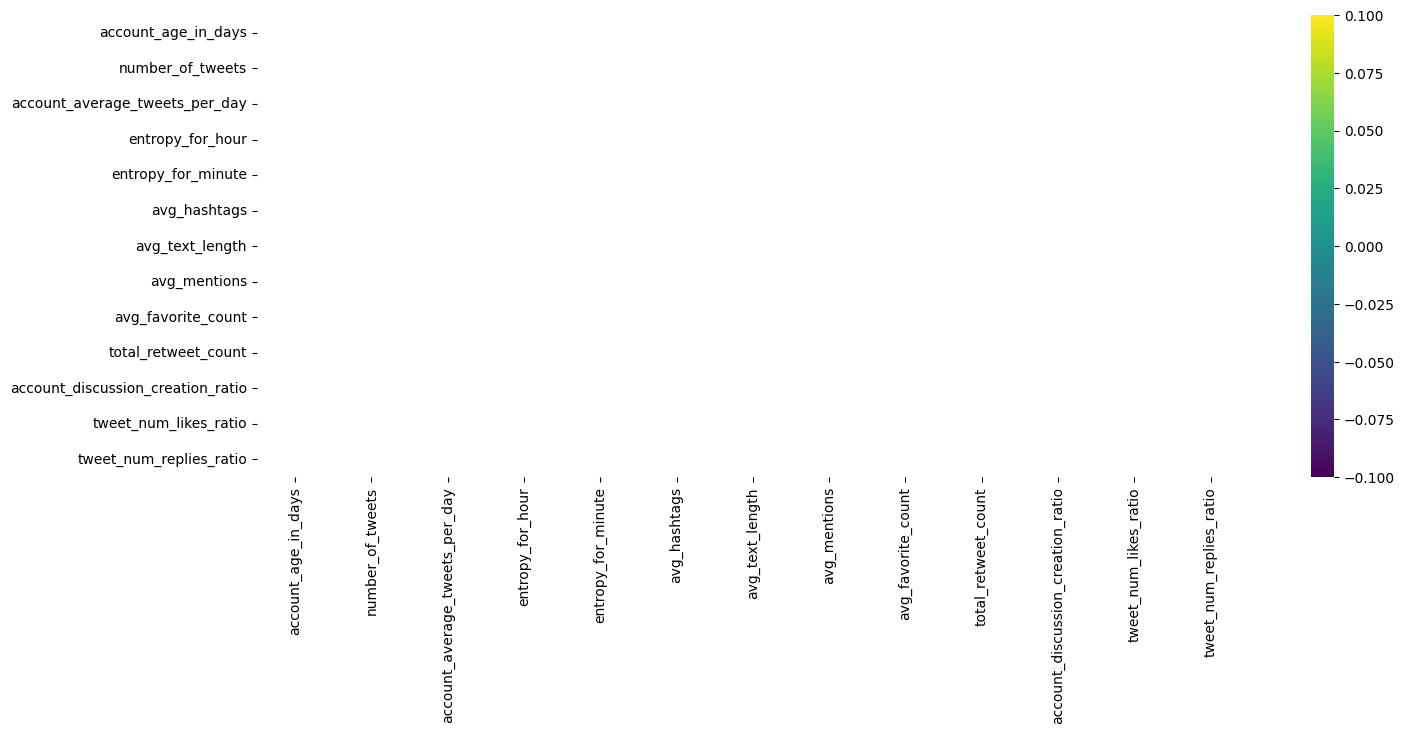

In [8]:
dfCorr = users_df.corr(method="spearman")
filteredDf = dfCorr[((dfCorr >= .8) | (dfCorr <= -.8)) & (dfCorr !=1.000)] # We need to find the best correlation treshold
# https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm#:~:text=Correlation%20coefficients%20whose%20magnitude%20are%20between%200.7%20and%200.9%20indicate,can%20be%20considered%20moderately%20correlated.
plt.figure(figsize=(16,6))
sns.heatmap(filteredDf, annot=True, cmap="viridis",mask=np.triu(filteredDf))
plt.show()

## Clustering Preprocessing - Normalization  
A good practice in clustering is to avoid the bias given by the range of the different attributes, is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [6]:
# Defining scaler

# scaler = MinMaxScaler()
scaler = StandardScaler() # Employing Z-score, too narmolize every column, while keeping minimum and meximum value, as well as normalizing in terms of standard deviation and variance.
# https://www.researchgate.net/post/If-I-cluster-with-min-max-normalization-I-get-different-results-than-if-I-cluster-with-Z-score-normalization-how-should-I-proceed
scaler.fit(users_df.values)

StandardScaler()

In [7]:
users_df.head().values

array([[1.31400000e+03, 1.26000000e+02, 5.78386606e-02, 2.76294359e+00,
        1.86753882e+00, 1.03174603e-01, 6.46190476e+01, 2.85714286e-01,
        3.96825397e-02, 5.00000000e+00, 2.52000000e+01, 2.52000000e+01,
        0.00000000e+00],
       [1.31100000e+03, 1.16000000e+02, 4.11899314e-02, 2.88181616e+00,
        1.90961363e+00, 2.58620690e-02, 7.04913793e+01, 3.44827586e-01,
        5.17241379e-02, 3.00000000e+00, 3.86666667e+01, 1.93333333e+01,
        0.00000000e+00],
       [2.70900000e+03, 4.00000000e+00, 1.10741971e-03, 9.18295834e-01,
        9.18295834e-01, 0.00000000e+00, 1.92500000e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.08000000e+03, 1.35800000e+03, 2.40384615e-02, 1.32078498e+00,
        4.74757602e-01, 8.17378498e-02, 8.93858616e+01, 6.62739323e-03,
        1.85567010e-01, 1.18700000e+03, 1.14406066e+00, 5.38888889e+00,
        0.00000000e+00],
       [1.19800000e+03, 3.43400000e+

In [9]:
scaler.transform(users_df.head().values)

array([[-9.25297699e-01, -6.80086223e-01, -3.01268376e-01,
         7.05757769e-01,  1.25299142e+00, -2.28875650e-01,
        -3.44915318e-01, -2.17073608e-01, -5.26599001e-02,
        -1.79607870e-01,  7.02287462e-02,  1.68164371e-01,
        -1.42292933e-01],
       [-9.30702476e-01, -6.88424330e-01, -3.25721141e-01,
         8.15138474e-01,  1.31499720e+00, -5.60218992e-01,
         7.28611632e-03, -5.83592052e-02, -5.26240335e-02,
        -1.79608553e-01,  2.36567603e-01,  4.17670839e-02,
        -1.42292933e-01],
       [ 1.58792389e+00, -7.81811128e-01, -3.84592197e-01,
        -9.91596500e-01, -1.45910652e-01, -6.71057739e-01,
        -3.06598839e+00, -9.84193220e-01, -5.27780965e-02,
        -1.79609576e-01, -2.41039016e-01, -3.74769431e-01,
        -1.42292933e-01],
       [ 4.54722183e-01,  3.47168557e-01, -3.50912306e-01,
        -6.21245756e-01, -7.99554200e-01, -3.20748534e-01,
         1.14050953e+00, -9.66399208e-01, -5.22253757e-02,
        -1.79204590e-01, -2.26907698e

In [10]:
scaler.inverse_transform(scaler.transform(users_df.head().values))

array([[1.31400000e+03, 1.26000000e+02, 5.78386606e-02, 2.76294359e+00,
        1.86753882e+00, 1.03174603e-01, 6.46190476e+01, 2.85714286e-01,
        3.96825397e-02, 5.00000000e+00, 2.52000000e+01, 2.52000000e+01,
        0.00000000e+00],
       [1.31100000e+03, 1.16000000e+02, 4.11899314e-02, 2.88181616e+00,
        1.90961363e+00, 2.58620690e-02, 7.04913793e+01, 3.44827586e-01,
        5.17241379e-02, 3.00000000e+00, 3.86666667e+01, 1.93333333e+01,
        0.00000000e+00],
       [2.70900000e+03, 4.00000000e+00, 1.10741971e-03, 9.18295834e-01,
        9.18295834e-01, 0.00000000e+00, 1.92500000e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.08000000e+03, 1.35800000e+03, 2.40384615e-02, 1.32078498e+00,
        4.74757602e-01, 8.17378498e-02, 8.93858616e+01, 6.62739323e-03,
        1.85567010e-01, 1.18700000e+03, 1.14406066e+00, 5.38888889e+00,
        0.00000000e+00],
       [1.19800000e+03, 3.43400000e+

In [11]:
X = scaler.fit_transform(users_df.values)

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [12]:
dbscan = DBSCAN(eps=0.15, min_samples=3)
dbscan.fit(X)

DBSCAN(eps=0.15, min_samples=3)

Output:
* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

In [17]:
dbscan.labels_[:5]

array([ 0, -1, -1,  1, -1], dtype=int64)

Observing the size of each cluster

In [18]:
np.unique(dbscan.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121], dtype=int64),
 array([8947,    3,  645,  865,    3,    8,    3,    4,   19,    4,    4,
          32,    8,   35,    4,    4,   15,    6,    5,   52,    4,    5,
           3,    3,   29,   12,    3,    3,    6,    3,    6,    9,    3,
           3,    6,    3,    5,    5,    4,    5,    7,    5,    4, 

Visualization of the clustering in two dimensions.

In [ ]:
plt.scatter(df['tip'], df['tip_ratio'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()